In [1]:
import sys
sys.path.append(r'W:\pipeline')

#USE pipeline ENV
!conda info
import numpy as np
import napari
print(np.__version__)
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import re

from cellpose import utils, io
from cellpose import models, plot
from skimage.measure import label,regionprops
from skimage import morphology, measure
import seaborn as sns
import itertools
import pandas as pd
# import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import math
from sklearn.neural_network import MLPClassifier
import statistics
import pickle
import os
import skimage
import tqdm
from datetime import datetime
from skimage.measure import regionprops_table
import warnings
warnings.filterwarnings('ignore')


from utils_img_new import Img, random_forest, plot_box_by_cells_idx, create_training_set
import utils_img_new
%reload_ext autoreload
%autoreload 2


     active environment : piplnew
    active env location : C:\Users\yedidyab\Anaconda3\envs\piplnew
            shell level : 1
       user config file : C:\Users\yedidyab\.condarc
 populated config files : C:\Users\yedidyab\.condarc
          conda version : 22.9.0
    conda-build version : 3.22.0
         python version : 3.9.13.final.0
       virtual packages : __cuda=12.2=0
                          __win=0=0
                          __archspec=1=x86_64
       base environment : C:\Users\yedidyab\Anaconda3  (writable)
      conda av data dir : C:\Users\yedidyab\Anaconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://conda.anaconda.org/conda-forge/win-64
                          https://conda.anaconda.org/conda-forge/noarch
                          https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          

## Setting Up Directory Paths

In [6]:
# Specify the directory paths
exp_path = r'X:\danielda\analysis\zp_late_exp_100x_010724'
image_directory_path = rf'{exp_path}\image_projections'
segmentation_directory_base_path = rf'{exp_path}\segmentation'
cell_by_gene_dir = rf'{exp_path}\cell_by_gene'

save_path = rf'W:\pipeline\dv_masks2'
# If the directory does not exist, create it
if not os.path.exists(save_path):
    os.makedirs(save_path)


## Creating the Training Set

In [15]:
training_set = create_training_set(image_directory_path, segmentation_directory_base_path, fov_to_include = range(41), hyb=1)
print(training_set)


[('X:\\danielda\\analysis\\zp_late_exp_100x_010724\\image_projections\\fov_27_hyb_0.phase.tif', 'X:\\danielda\\analysis\\zp_late_exp_100x_010724\\segmentation\\fov_27_hyb_1\\fov_27_hyb_1.seg.npy'), ('X:\\danielda\\analysis\\zp_late_exp_100x_010724\\image_projections\\fov_40_hyb_0.phase.tif', 'X:\\danielda\\analysis\\zp_late_exp_100x_010724\\segmentation\\fov_40_hyb_1\\fov_40_hyb_1.seg.npy'), ('X:\\danielda\\analysis\\zp_late_exp_100x_010724\\image_projections\\fov_11_hyb_0.phase.tif', 'X:\\danielda\\analysis\\zp_late_exp_100x_010724\\segmentation\\fov_11_hyb_1\\fov_11_hyb_1.seg.npy'), ('X:\\danielda\\analysis\\zp_late_exp_100x_010724\\image_projections\\fov_35_hyb_0.phase.tif', 'X:\\danielda\\analysis\\zp_late_exp_100x_010724\\segmentation\\fov_35_hyb_1\\fov_35_hyb_1.seg.npy'), ('X:\\danielda\\analysis\\zp_late_exp_100x_010724\\image_projections\\fov_0_hyb_0.phase.tif', 'X:\\danielda\\analysis\\zp_late_exp_100x_010724\\segmentation\\fov_0_hyb_1\\fov_0_hyb_1.seg.npy'), ('X:\\danielda\\a

## Model Training with Human Input

In [14]:
# human-in-the-loop

# ###############   FOR TRAINING ONLY   ###############

training_dfs=[]
features = ['logFC_axis_major_length', 'orientation_difference', 'axis_dist', 'min_dist_poles']

for file in tqdm.tqdm(sorted(training_set)):
    loading = 0
    image_path = file[0]
    seg = file[1]
    temp = Img(image_path)
    temp.get_segmentation(seg)

    name = image_path.split('\\')[-1].split(('.'))[0]
    mask_file = rf'{save_path}\{name}_masks.npy'
    pairs_file = rf'{save_path}\{name}_pairs.npy'
    not_pairs_file = rf'{save_path}\{name}_not_pairs.npy'

    if os.path.isfile(mask_file) and os.path.isfile(pairs_file) and os.path.isfile(not_pairs_file): # Load marked image
        print(f'load {mask_file}')
        temp.add_saved_masked_labels(mask_file, pairs_file, not_pairs_file)
        loading = 1

    elif 'model1' in locals(): # If there is a trained model
        temp.create_candidate_pairs()
        temp.calc_props()
        temp.build_pairs_df()
        temp.predict_division(model1)
        temp.show_prob(open_napari=False)
        temp.add_label_layer()
        temp.defind_masks_as()

    else:
        temp.add_label_layer()
        temp.defind_masks_as()

    if len(temp.pair) != 0: # If somthing is marked
        temp.create_candidate_pairs()
        temp.calc_props()
        temp.build_pairs_df()
        temp.pairs_df['value'] = temp.pairs_df.apply(utils_img_new.add_value_column, axis=1, pairs=temp.pair, not_pairs=temp.not_pairs)
        train = temp.pairs_df[temp.pairs_df['value'].notna()]
        training_dfs.append(train)
        train_df = pd.concat(training_dfs, ignore_index=True)

        #split the data(80%) to train and test(20%)
        X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df.value,
                                                        test_size=0.2,
                                                        random_state=42)
        n_in_div = (train_df['value'] == 1).sum()
        n_not_in_div = (train_df['value'] == 0).sum()
        print(f'train on {n_in_div} in_div and {n_not_in_div} not_in_div')
        model1=random_forest(X_train, X_test, y_train, y_test, plot = False)


        np.save(rf'{save_path}\{name}_masks.npy', temp.masks)
        np.save(rf'{save_path}\{name}_pairs.npy', temp.pair)
        np.save(rf'{save_path}\{name}_not_pairs.npy', temp.not_pairs)

    if loading == 0 and input('quit training? (y/n)') == 'y':
            break


  0%|          | 0/5 [00:00<?, ?it/s]

load W:\pipeline\dv_masks2\fov_0_hyb_0_masks.npy
train on 28 in_div and 25 not_in_div
Mean accuracy score: 0.818


 20%|██        | 1/5 [00:05<00:20,  5.17s/it]

load W:\pipeline\dv_masks2\fov_1_hyb_0_masks.npy
train on 60 in_div and 51 not_in_div
Mean accuracy score: 0.87


 40%|████      | 2/5 [00:11<00:16,  5.59s/it]

load W:\pipeline\dv_masks2\fov_2_hyb_0_masks.npy
train on 92 in_div and 89 not_in_div
Mean accuracy score: 0.919


 60%|██████    | 3/5 [00:17<00:11,  5.80s/it]

load W:\pipeline\dv_masks2\fov_3_hyb_0_masks.npy
train on 132 in_div and 120 not_in_div
Mean accuracy score: 0.941


 80%|████████  | 4/5 [00:23<00:06,  6.05s/it]

C:\Users\yedidyab\Anaconda3\envs\piplnew\lib\..\LICENSE.txt
C:\Users\yedidyab\Anaconda3\envs\piplnew\lib\..\LICENSE


 80%|████████  | 4/5 [2:33:24<38:21, 2301.04s/it]


1## Generating Pairplot for Feature Analysis

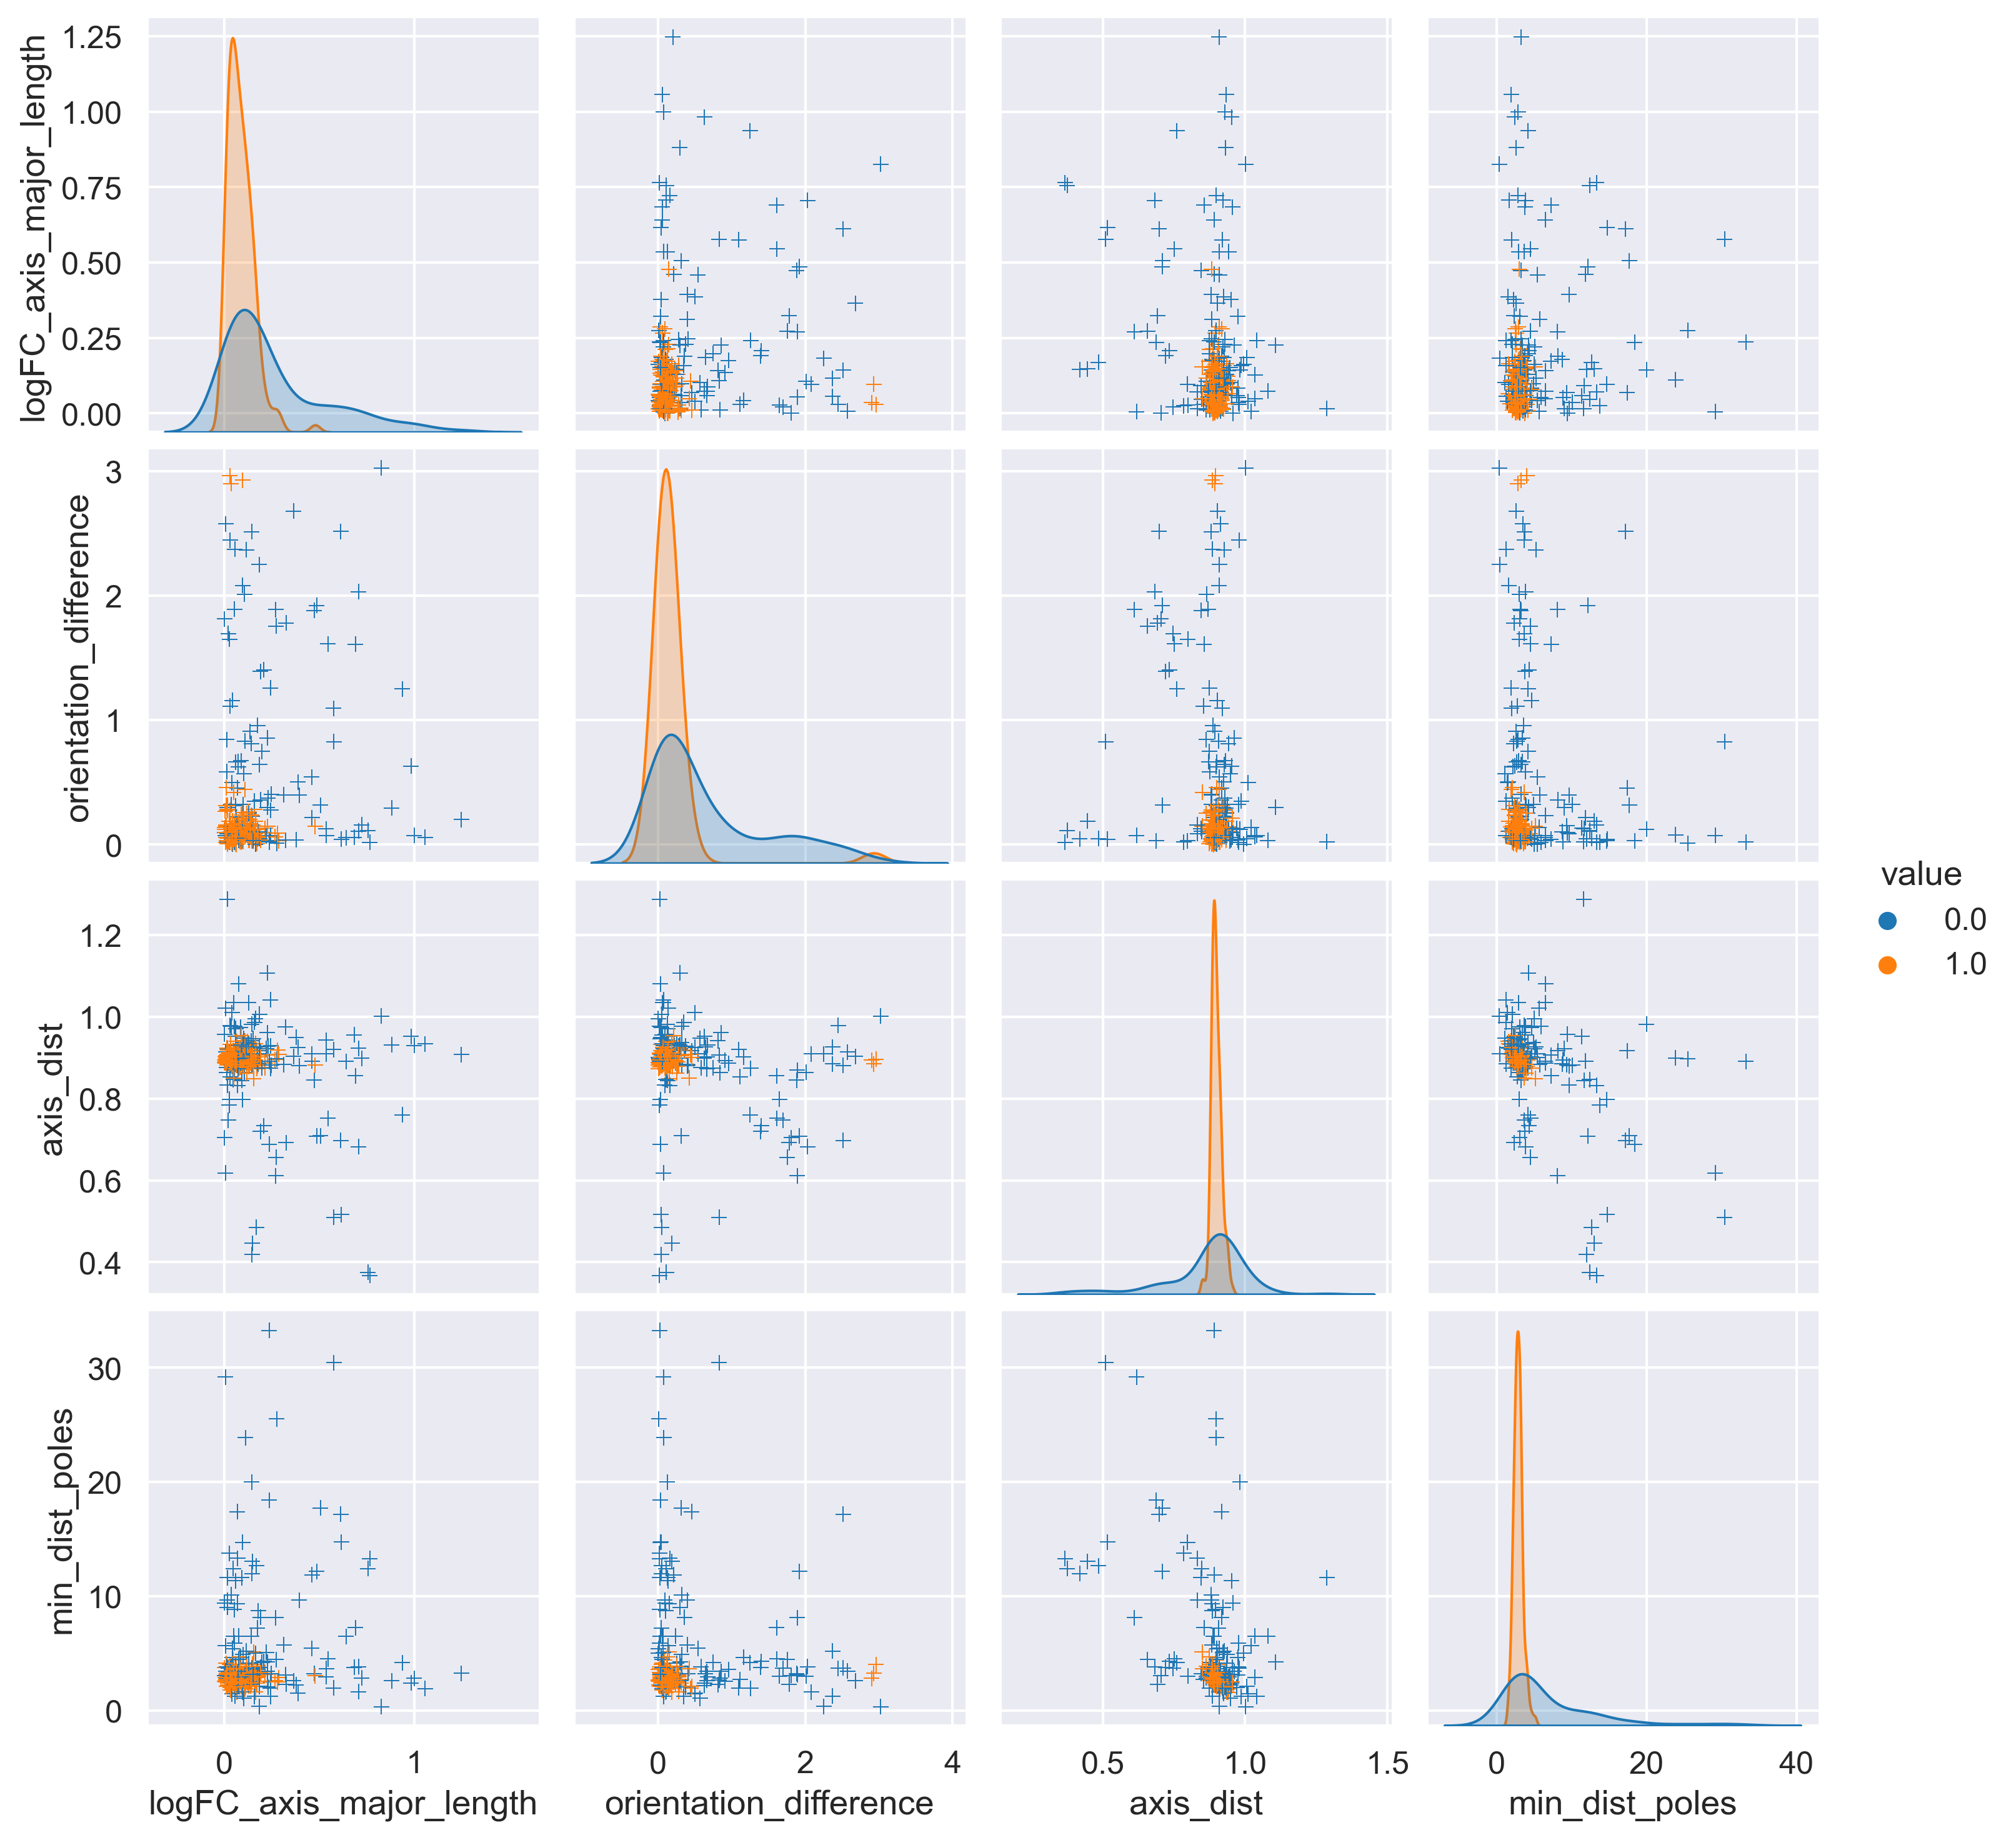

In [6]:
sns.set_context("notebook", font_scale=1.1)
sns.pairplot(train_df[['logFC_axis_major_length', 'orientation_difference', 'axis_dist','min_dist_poles','value']], hue='value', markers="+")

plt.savefig(rf'{save_path}\pairplot.png')


## Splitting Data and Training Random Forest Classifier

Mean accuracy score: 0.941


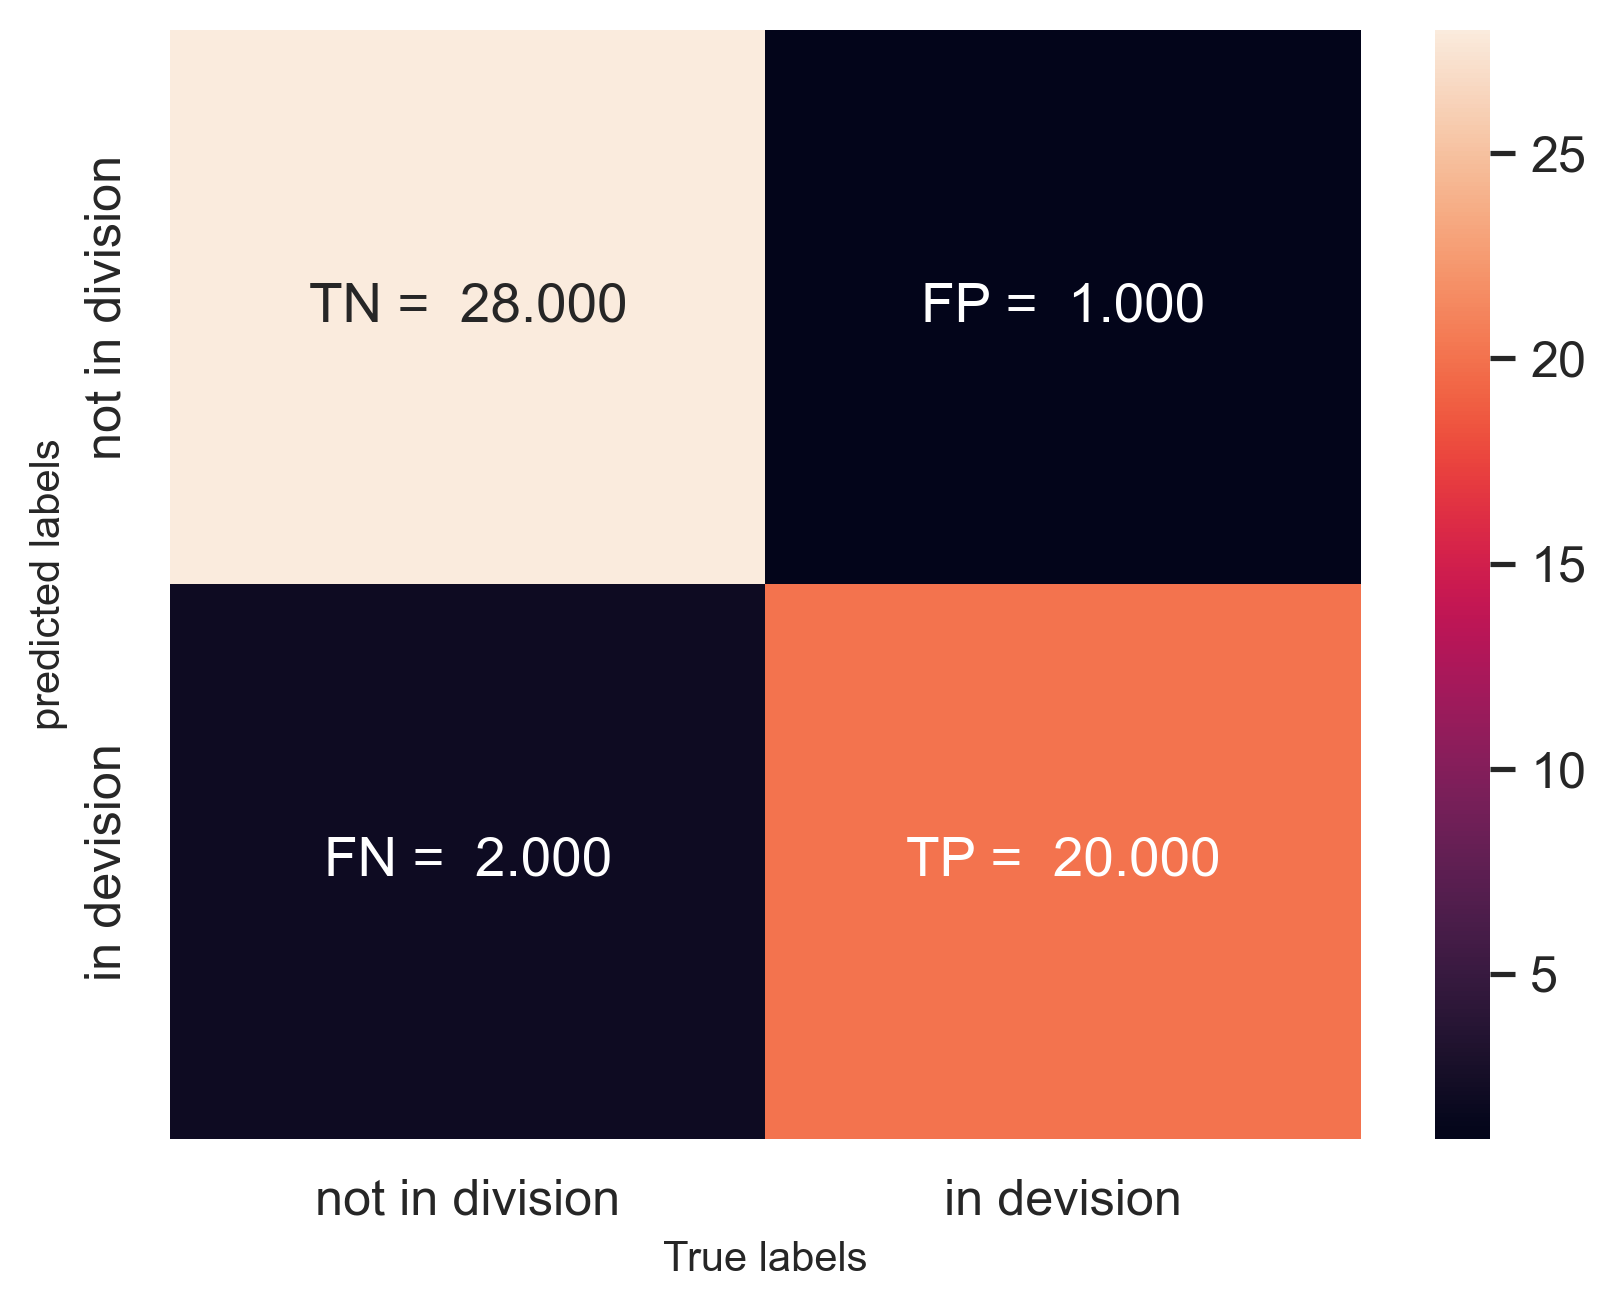

In [7]:
features = ['logFC_axis_major_length', 'orientation_difference', 'axis_dist', 'min_dist_poles']
#split the data(80%) to train and test(20%)
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df.value,
        test_size=0.2,
        random_state=42)

rf_cls=random_forest(X_train, X_test, y_train, y_test)

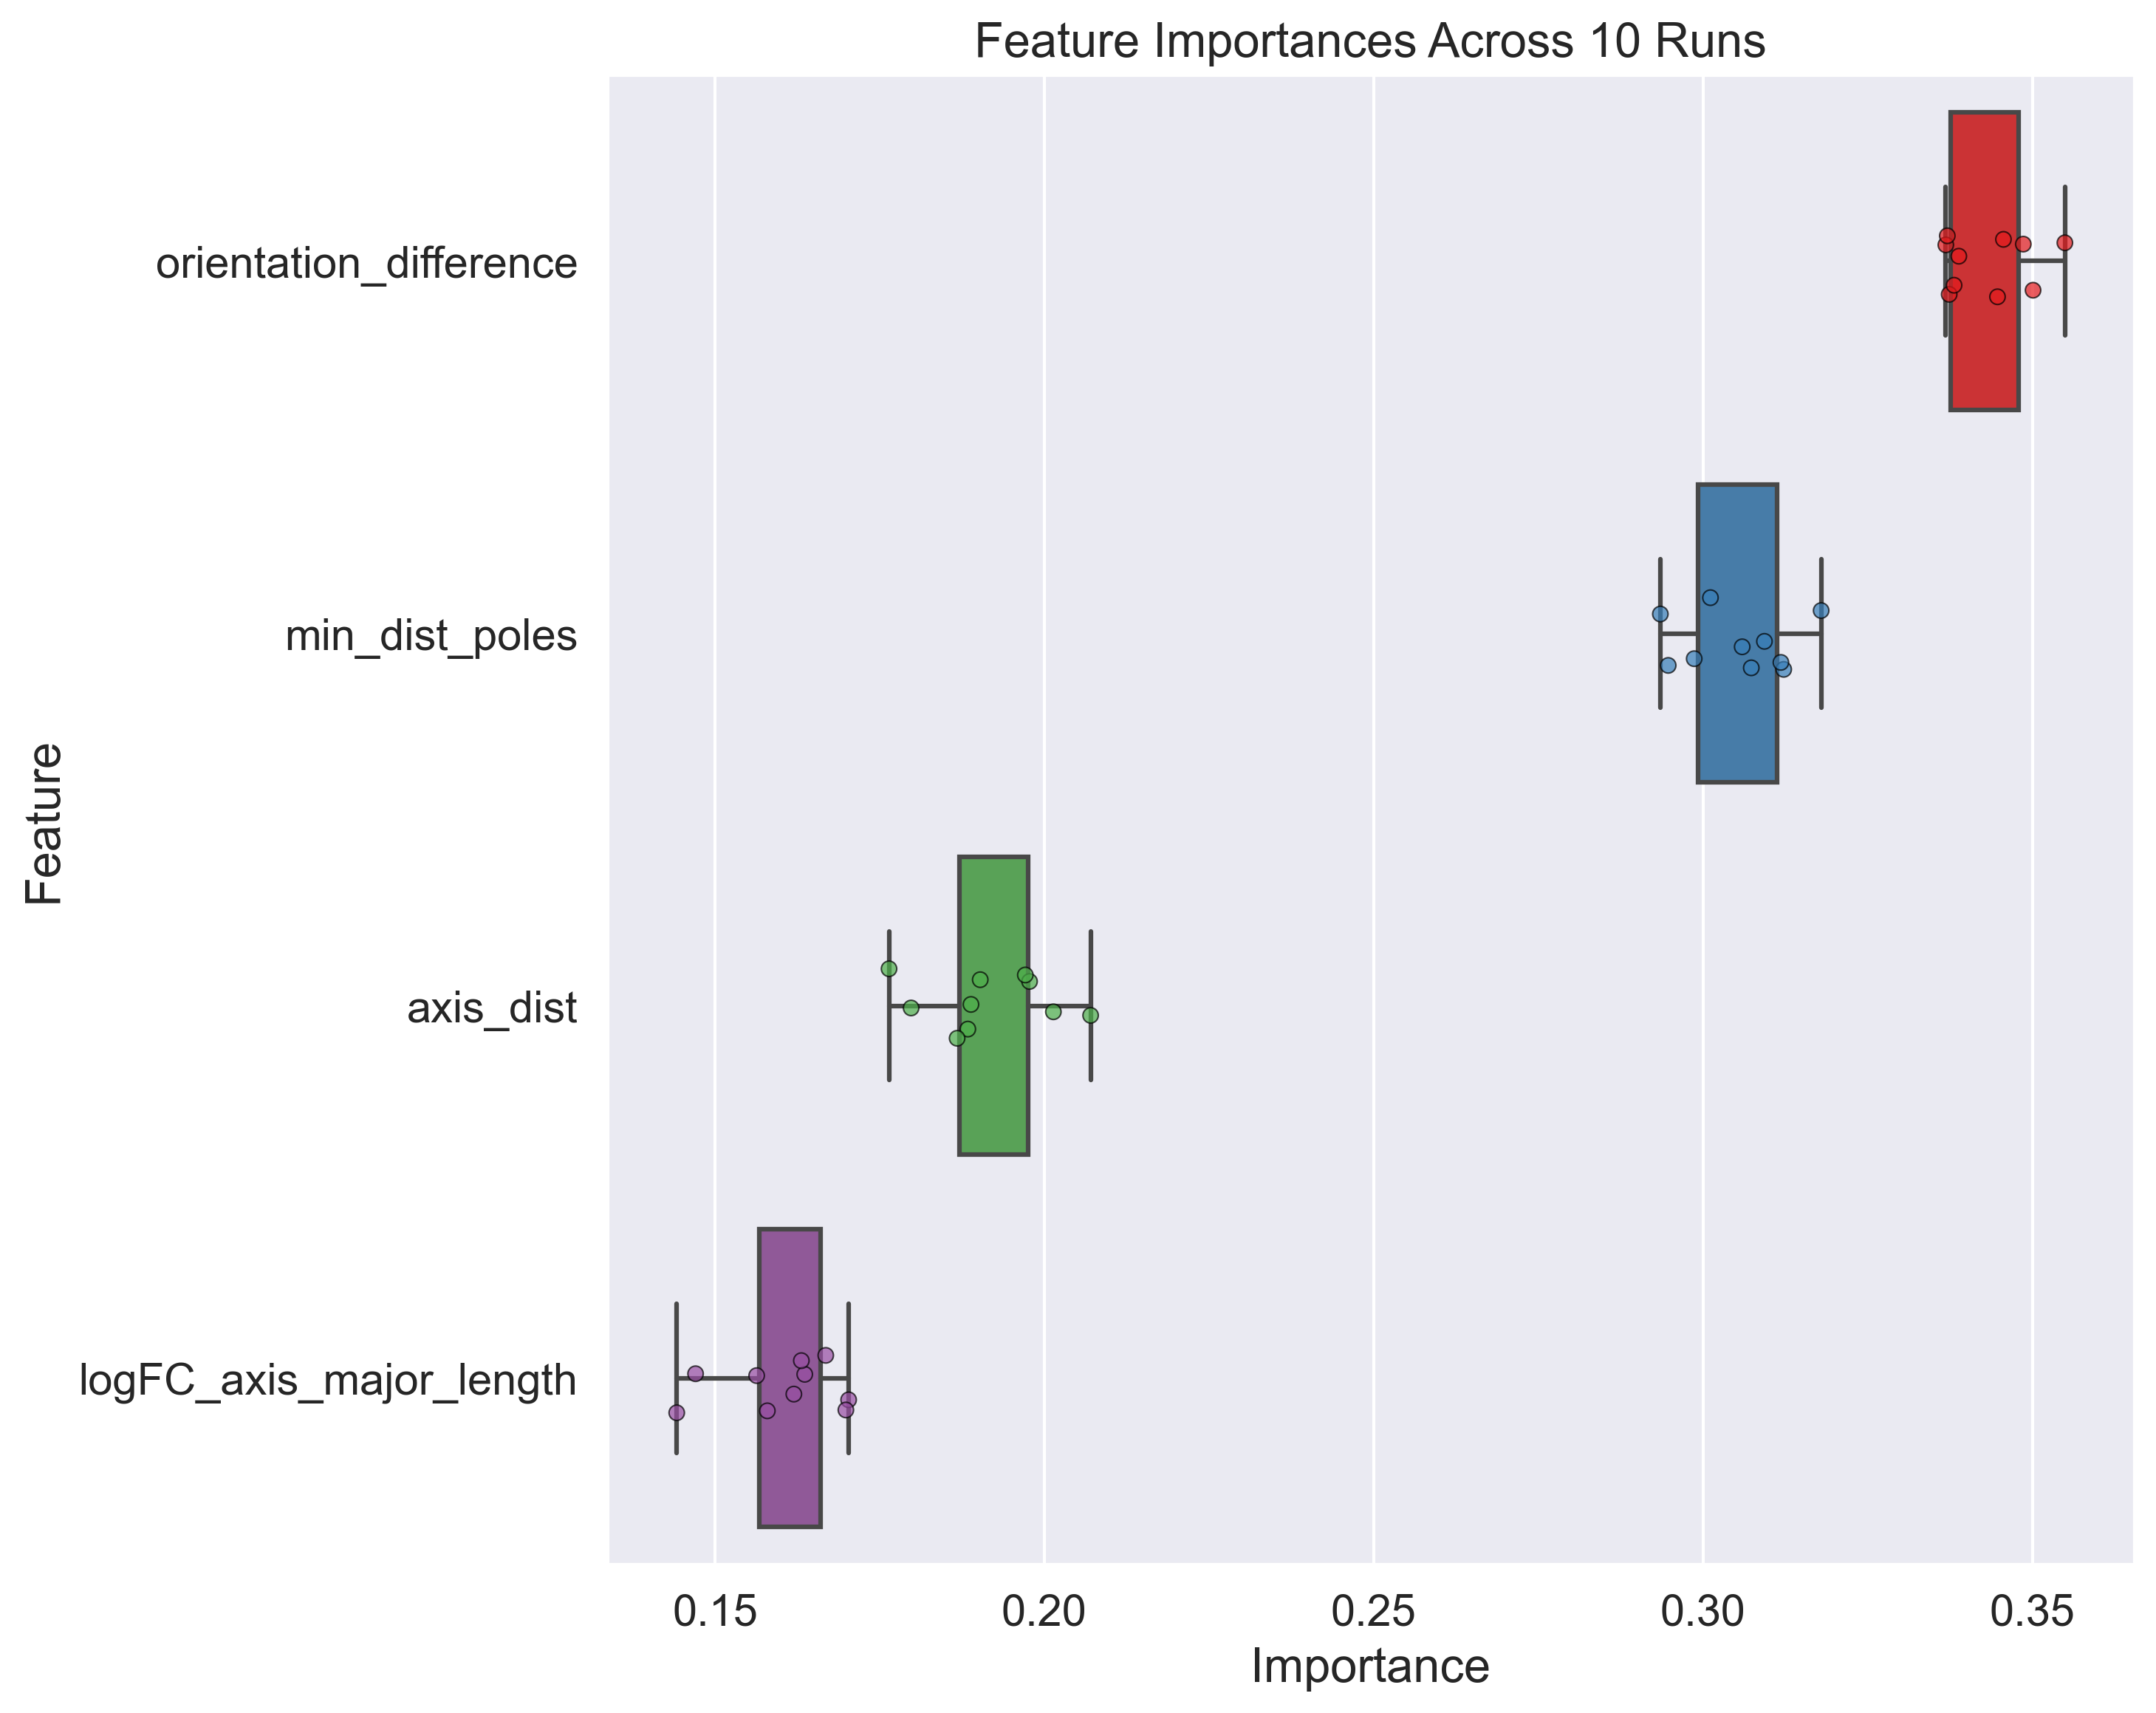

In [9]:

# Function to train RandomForest and return feature importances
def random_forest(X_train, y_train, random_state):
    rf_cls = RandomForestClassifier(random_state=random_state)
    rf_cls.fit(X_train, y_train)
    return rf_cls.feature_importances_

# Placeholder for feature importances
feature_importances = []
features = X_train.columns  # Assuming X_train is a DataFrame

# Train the model 10 times with different random states and collect feature importances
for i in range(10):
    importances = random_forest(X_train, y_train, random_state=i)
    for j, imp in enumerate(importances):
        feature_importances.append({'Feature': features[j], 'Importance': imp, 'Run': i})

# Convert to DataFrame
importances_df = pd.DataFrame(feature_importances)

# Calculate median importance for each feature and sort features based on median importance
median_importances = importances_df.groupby('Feature')['Importance'].median().sort_values(ascending=False)
sorted_features = median_importances.index

# Reorder the DataFrame based on sorted features
importances_df['Feature'] = pd.Categorical(importances_df['Feature'], categories=sorted_features, ordered=True)
importances_df = importances_df.sort_values('Feature')

# Plot the boxplot with stripplot using seaborn
plt.figure(figsize=(10, 8))
sns.set_context("notebook", font_scale=1.3)

sns.boxplot(x='Importance', y='Feature', data=importances_df, palette="Set1", showfliers=False, medianprops={'color':'none'})
sns.stripplot(x='Importance', y='Feature', data=importances_df, palette='Set1', alpha=0.7, jitter=True, marker='o', edgecolor='k', linewidth=0.5)
plt.title('Feature Importances Across 10 Runs')
plt.tight_layout()

# Save the plot with high quality
plt.savefig(fr'{save_path}\feature_importances_plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [46]:
## Pair Prediction Across All Images

In [24]:
# Loop over all images and
pairs_dfs = []
props_dfs_individual = []
for paths in tqdm.tqdm(training_set):
    fov = re.search(r'fov_(\d+)', paths[0]).group(1)
    temp = Img(paths[0])
    temp.get_segmentation(paths[1])
    temp.create_candidate_pairs()
    temp.calc_props()
    temp.build_pairs_df()
    temp.predict_division(model1)
    temp.add_cell_by_gene(rf'{cell_by_gene_dir}\fov_{fov}_cell_by_gene.raw.txt')
    pairs_dfs.append(temp.pairs_df)
    props_dfs_individual.append(temp.props_df_indevedual)


all_pairs_df = pd.concat(pairs_dfs)
all_props_dfs_individual = pd.concat(props_dfs_individual)


100%|██████████| 38/38 [02:12<00:00,  3.48s/it]


In [25]:
len(all_props_dfs_individual)

104303

In [26]:
all_props_dfs_individual[all_props_dfs_individual.is_div][['field_of_view', 'cell_id', 'pair', 'axis_major_length']].to_csv(fr'C:\Users\yedidyab\Downloads\dv_new\is_div_individual.csv')
all_pairs_df[['idx1', 'idx2', 'idx1_fov', 'is_dividing', 'log_proba']].to_csv(fr'C:\Users\yedidyab\Downloads\dv_new\is_div_pairs.csv')

## Analyzing Division Event Frequency by Sample

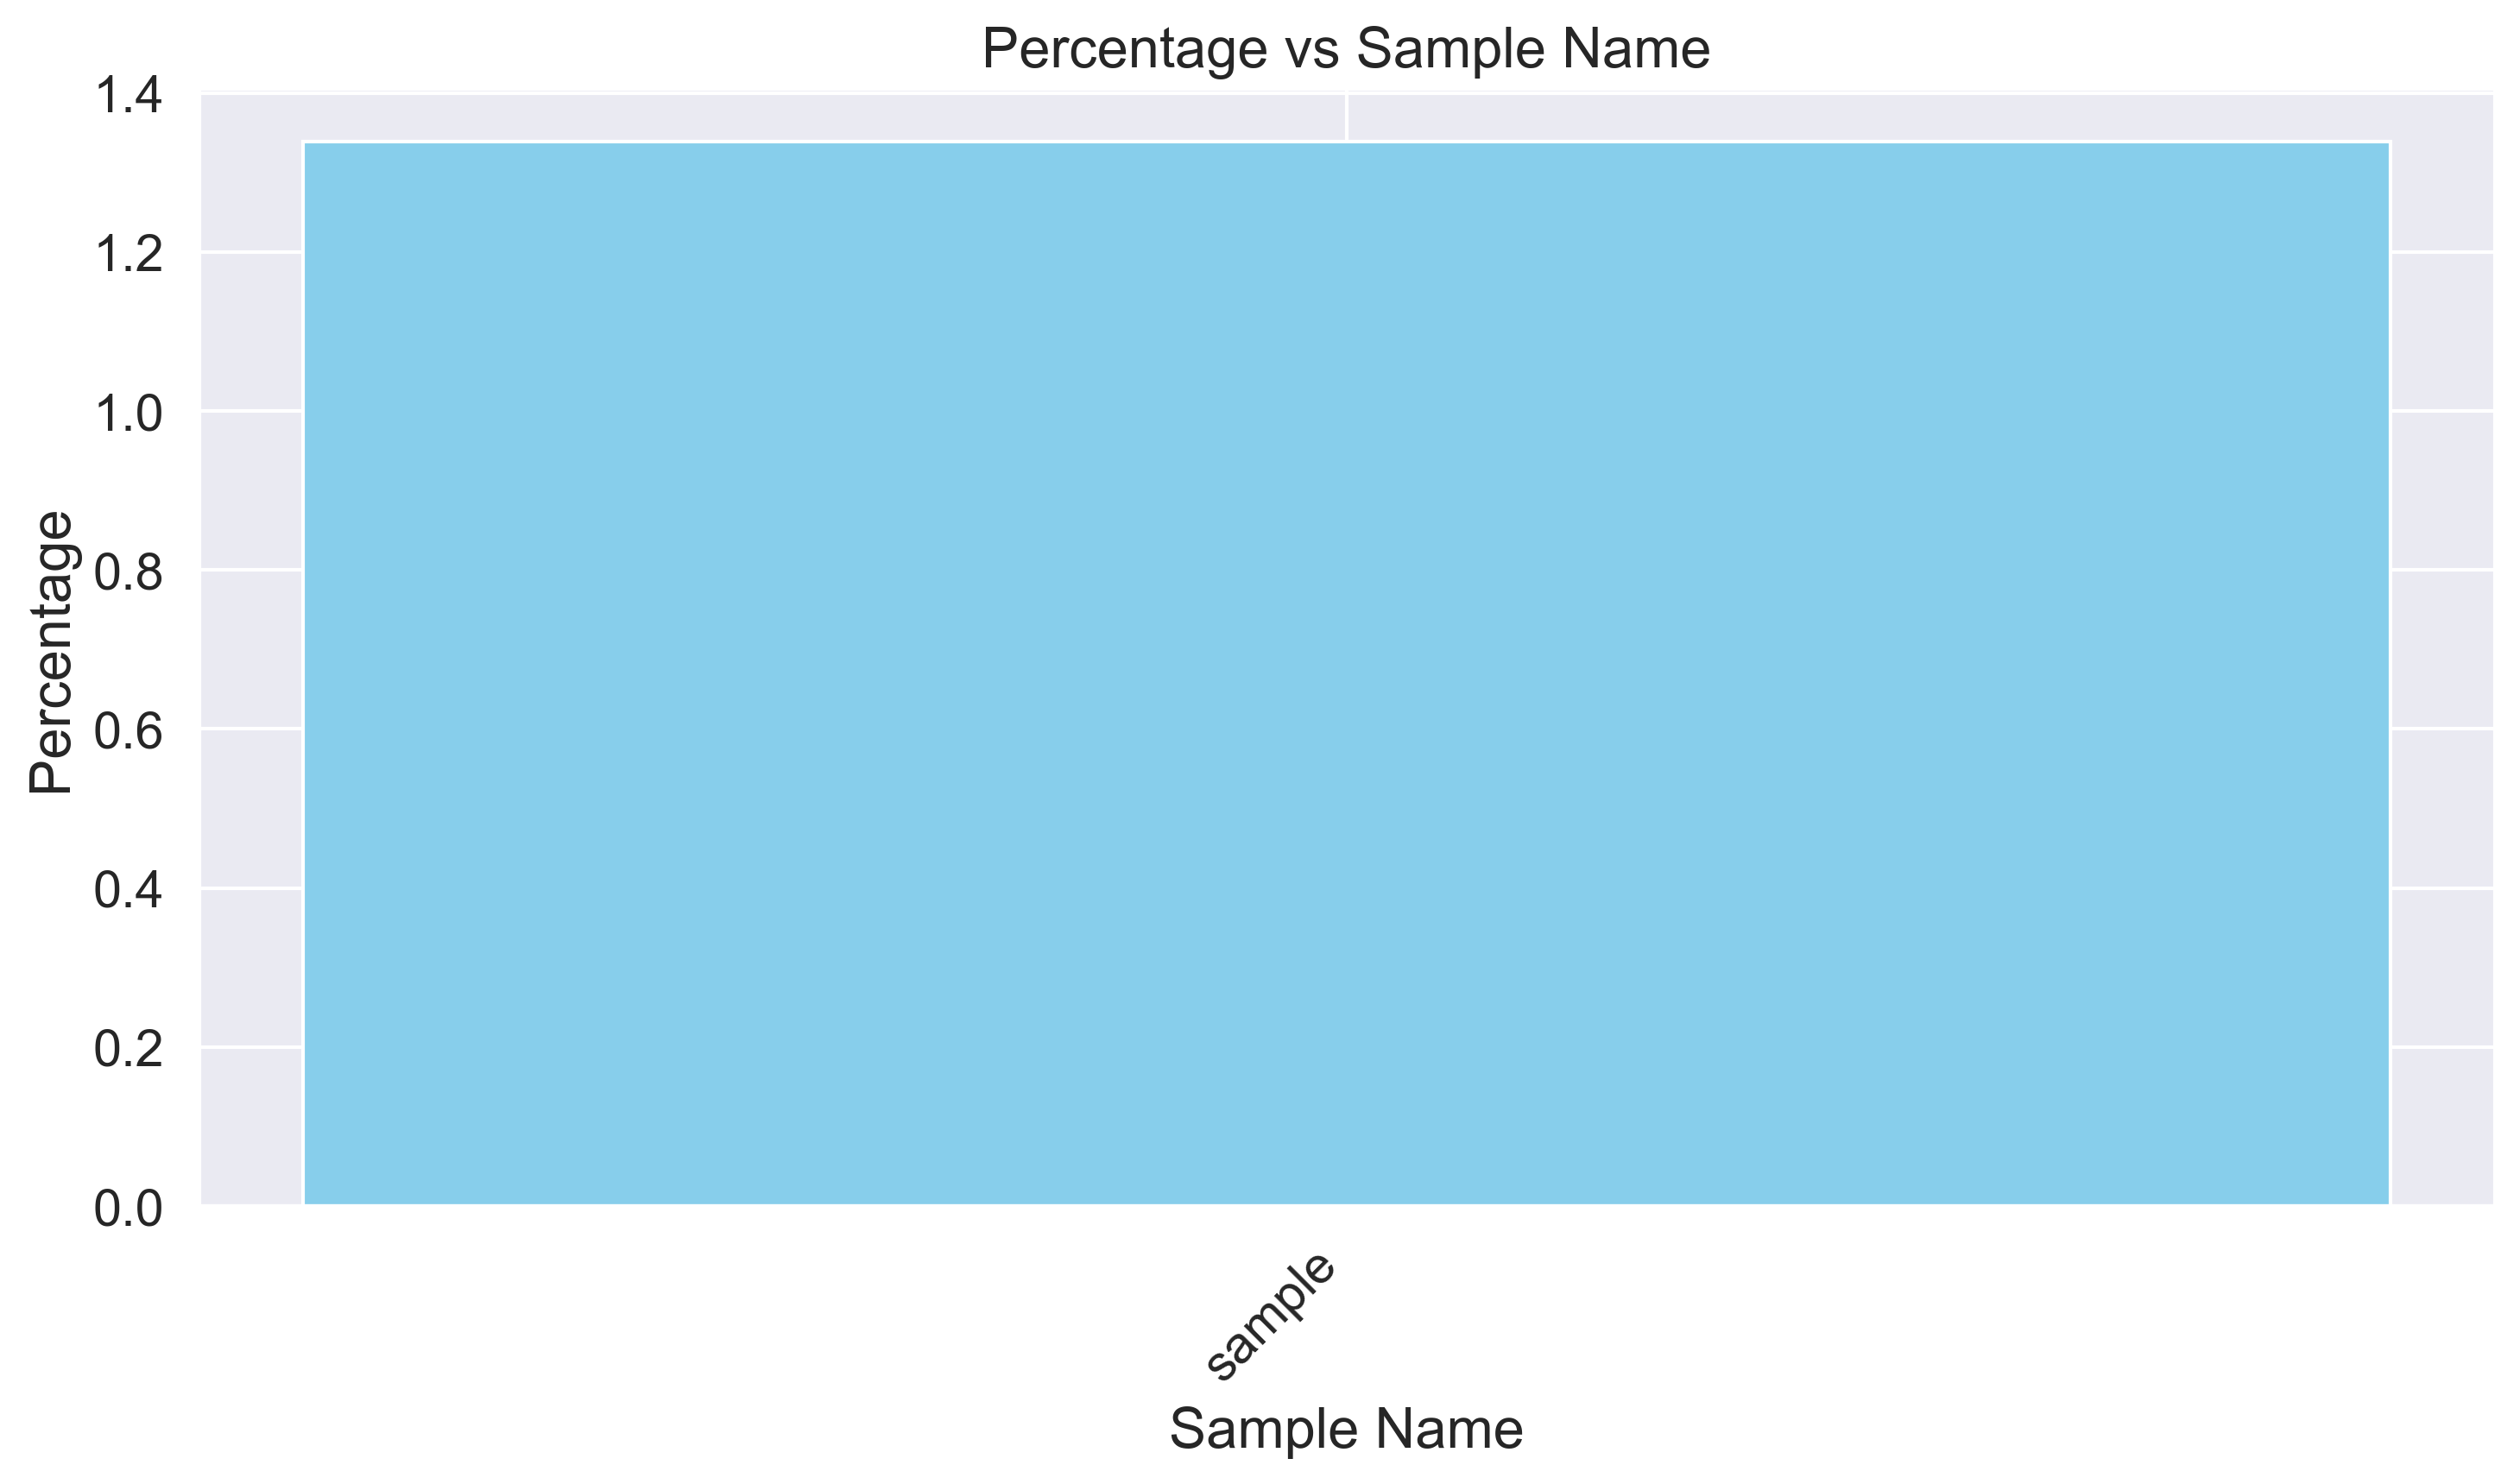

In [14]:
pairs_count = all_props_dfs_individual.dropna(subset = 'pair').sample_name.value_counts().rename_axis('sample_name').reset_index(name='counts')
all_count = all_props_dfs_individual.sample_name.value_counts().rename_axis('sample_name').reset_index(name='counts')
all_count['percentage'] = (pairs_count['counts']/all_count['counts'])*100

# Sorting the DataFrame by sample_name
df_sorted = all_count.sort_values(by='sample_name')

# Plotting the sorted data
plt.figure(figsize=(10, 6))
plt.bar(df_sorted['sample_name'], df_sorted['percentage'], color='skyblue')
plt.xlabel('Sample Name')
plt.ylabel('Percentage')
plt.title('Percentage vs Sample Name')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(rf'{save_path}\Div Percentage vs Sample Name.png')
plt.show()

## Quality Assurance: Visualizing Randomly Selected Dividing Pairs

In [9]:
import numpy as np
import cv2

def extract_outlines(image):
    """
    Extracts the outlines of segmented regions in an image.

    Parameters:
        image (np.array): A grayscale image where different segments are represented by different intensities.

    Returns:
        np.array: An image with only the outlines of the segmented regions.
    """
    # Ensure the image is in the correct format (grayscale)
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find all unique labels in the image
    unique_labels = np.unique(image)

    # Create an empty image to draw the outlines
    outlines_image = np.zeros_like(image, dtype=np.uint8)  # Ensure data type is np.uint8

    for label in unique_labels:
        # Create a binary mask for the current label
        mask = np.where(image == label, 1, 0).astype(np.uint8)

        # Find contours for the current label
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw the contours on the outlines image
        cv2.drawContours(outlines_image, contours, -1, 255, 1)  # Use 255 for white

    return outlines_image

In [12]:
segmentation_directory_base_path

'X:\\danielda\\analysis\\zp_late_exp_100x_010724\\segmentation'

4it [00:01,  2.97it/s]


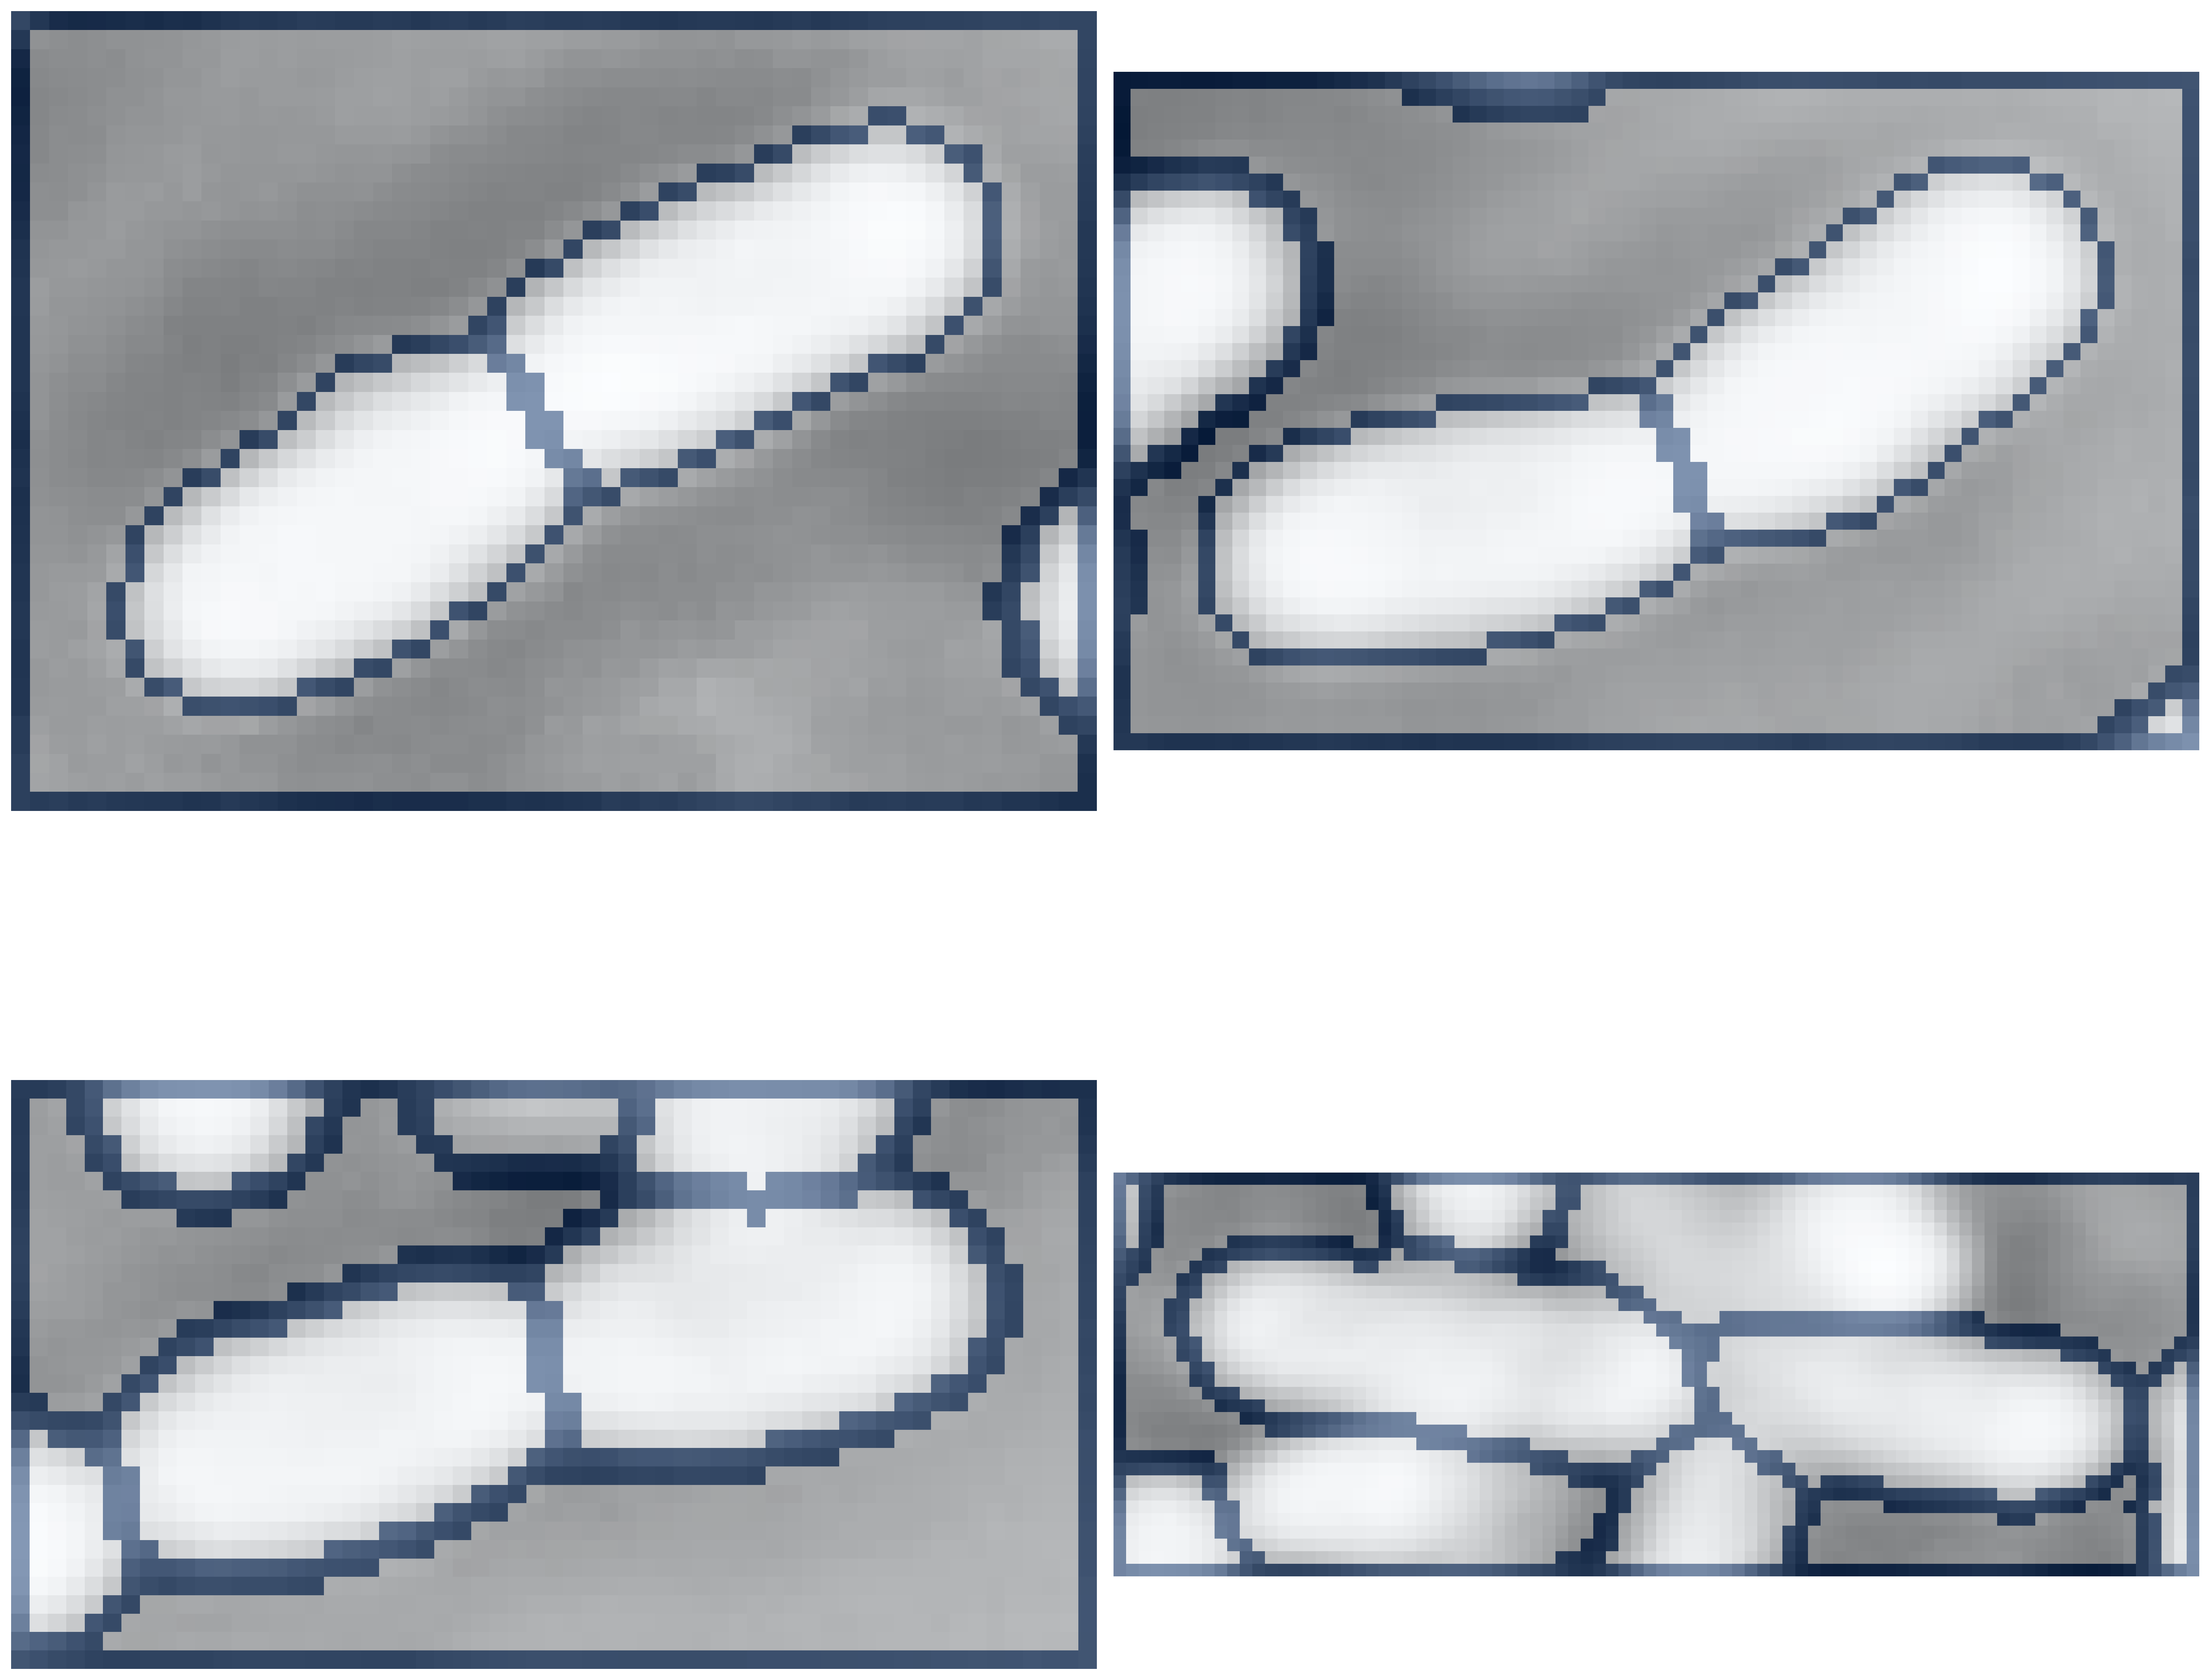

In [10]:

# QA - plot random pairs
selected_pairs = all_pairs_df[all_pairs_df.is_dividing == 1].sample(4)[['idx1', 'idx2', 'idx1_fov']]

# Set up a 5x5 grid of plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
# Flatten the array of axes so we can iterate over it more easily
axes = axes.flatten()

for i, (index, row) in tqdm.tqdm(enumerate(selected_pairs.iterrows())):
    fov =row['idx1_fov']
    img_path = rf'{image_directory_path}\\fov_{fov}_hyb_1.phase.tif'
    seg_path = rf'{segmentation_directory_base_path}\\fov_{fov}_hyb_1\\fov_{fov}_hyb_1.seg.npy'
    temp = Img(img_path)
    temp.get_segmentation(seg_path)
    image_mat = plot_box_by_cells_idx(temp.img, temp.masks, row['idx1'], row['idx2'], plot_img=True)
    mask_mat = plot_box_by_cells_idx(temp.img, temp.masks, row['idx1'], row['idx2'], plot_img=False)
    if mask_mat is not None:
        # Plot the mask on the ith subplot
        axes[i].imshow(image_mat, cmap = 'Greys', alpha=1)
        axes[i].imshow(extract_outlines(mask_mat), cmap = 'Blues', alpha=.5)
        axes[i].axis('off')  # Hide the axis
    else:
        # In case the cells are not found and None is returned, just hide the axis
        axes[i].axis('off')

plt.tight_layout()
plt.savefig(rf'{save_path}\random pairs.png')
# plt.show()

In [99]:
save_path

'W:\\pipeline\\dv_masks2'

In [83]:
plot_box_by_cells_idx(temp.img, temp.masks, row['idx1'], row['idx2'], plot_img=T)

array([[1606, 1606, 1606, ...,    0,    0,    0],
       [1606, 1606, 1606, ...,    0,    0,    0],
       [1606, 1606, 1606, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ..., 1667, 1667, 1667],
       [   0,    0,    0, ..., 1667, 1667, 1667],
       [   0,    0,    0, ..., 1667, 1667, 1667]], dtype=int64)